<a href="https://colab.research.google.com/github/Samarth745/Credit-Card-Risk-Analysis/blob/main/Slam_ANalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [101]:
#@title Import
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
from scipy.stats import chi2_contingency, pearsonr
import re

pd.set_option('display.max_columns', None)

import warnings
warnings.simplefilter(action='ignore')


In [102]:
#@title Import Main DataFrame
data = pd.read_csv("/content/drive/MyDrive/Credit Risk Analysis/CreditRisk/loan/loan.csv")

In [103]:
#@title Create Columns Defination Dictionary
## This Dictionary will define columns based on keys
ColDoc = pd.read_excel("/content/drive/MyDrive/Credit Risk Analysis/CreditRisk/LCDataDictionary.xlsx").set_index("LoanStatNew")["Description"].to_dict()

## Data Demographics and Issues in Data
- 887379 Rows, 74 Columns
- Two Id Columns `id, member_id`
- Target colum `loan_status`
- There Are a lot of missing values, some of the columns with more than 50% data missing
- No Duplications
- - No direct duplicated values
- - No member Id duplicated
- - No two members with same features
- All the datecolumns are in format (MM-YYYY), All Srings
- `timedelta features are in text format of types (<1 year, 10+ year etc)
- columns `policy code` has no unique values
- A lot of columns have hardly 30 unique values in it which can be termed as categorical



In [104]:
#@title Shape
f"Total Number of Rows in Data {data.shape[0]}, Total Number of Columns in Data{data.shape[1]}"

'Total Number of Rows in Data 887379, Total Number of Columns in Data74'

In [105]:
#@title Null Values in Data Frame
(data.isnull().sum()/data.shape[0]).sort_values(ascending=False)

dti_joint                    0.999426
annual_inc_joint             0.999424
verification_status_joint    0.999424
il_util                      0.979020
mths_since_rcnt_il           0.976549
                               ...   
total_pymnt                  0.000000
total_pymnt_inv              0.000000
total_rec_prncp              0.000000
total_rec_int                0.000000
out_prncp_inv                0.000000
Length: 74, dtype: float64

As We can see above some of the columns in data frame have 50% of data missing

In [106]:
#@title Direct Duplicates
data.duplicated().sum()

0

In [107]:
#@title Duplicate Entries for members
data.duplicated(subset="member_id").sum()

0

In [108]:
#@title Duplicated Features
data.drop(columns = ["id", "member_id"]).duplicated().sum()

0

In [109]:
#@title Checking the possibility of Categorical Columns
columnsuniquevalues=pd.DataFrame()
for column in data.columns:
  columnsuniquevalues=pd.concat([columnsuniquevalues,pd.DataFrame({column : [(data[column].nunique())]}).T])
  columnsuniquevalues.sort_values(by=0, inplace=True)

## Data Cleaning
- remove `id` and `member_id` columns (Not usable)
- remove all the columns with more than 50% data (Not usable)
- `term` contains binary item, Highly corelated
- - `term` needs to be converted to numeric column hence remove strings
- `emp_length` needs to be converted to numeric hence remove strings
- `title` column delete
- `earliest_cr_line` column delete

---
* MissingValues**
- `annual_inc` missing values handled by fillna(median)
- `emp_len` to be handled using mean
- `["delinq_2yrs",'inq_last_6mths',"open_acc", "pub_rec"]` fillna(mean) less weightage columns
- `revol_util` should be handled using median
- `last_pymnt_d` and `next_pymnt_d` can be removed (Date Columns with no reference)
-  fill `emp_title` with 'random' no information can be built based on prev knowledge

Further rows with null values will be deleted
expected data loss -- `< 0.005%`

---
## Analyse on

- `emp_title` seems to have a lot of empty values, The column seems to be imp after text processing based on random checks (EX: if director is present --> HIgh chances of no default etc)

In [110]:
#@title Now columns with Missing Values
data.isnull().sum()[data.isnull().sum().values!=0].sort_values(ascending=False).head(15)

dti_joint                    886870
annual_inc_joint             886868
verification_status_joint    886868
il_util                      868762
mths_since_rcnt_il           866569
total_cu_tl                  866007
inq_fi                       866007
all_util                     866007
max_bal_bc                   866007
open_rv_24m                  866007
open_rv_12m                  866007
total_bal_il                 866007
open_il_24m                  866007
open_il_12m                  866007
open_il_6m                   866007
dtype: int64

In [111]:
#@title Employee Title
print("-------------------The  data set distribution of loan_status when emp_title contains director -------------------------------------------------------")
data["emp_title"].fillna("random", inplace=True)
data[data["emp_title"].str.contains("irector")]["loan_status"].value_counts()/(data[data["emp_title"].str.contains("irector")]["loan_status"].value_counts()).sum()
temp = data.dropna()[data["emp_title"].str.contains("irector").dropna()]["loan_status"].value_counts()/(data.dropna()[data["emp_title"].str.contains("irector").dropna()]["loan_status"].value_counts()).sum()
print(temp)
print("-------------------While the normal data set distribution of loan_status is -------------------------------------------------------")
data.loan_status.value_counts()/data.shape[0]

-------------------The  data set distribution of loan_status when emp_title contains director -------------------------------------------------------
Series([], Name: loan_status, dtype: float64)
-------------------While the normal data set distribution of loan_status is -------------------------------------------------------


Current                                                0.678153
Fully Paid                                             0.234086
Charged Off                                            0.050991
Late (31-120 days)                                     0.013062
Issued                                                 0.009534
In Grace Period                                        0.007047
Late (16-30 days)                                      0.002656
Does not meet the credit policy. Status:Fully Paid     0.002240
Default                                                0.001374
Does not meet the credit policy. Status:Charged Off    0.000858
Name: loan_status, dtype: float64

<Axes: ylabel='emp_length'>

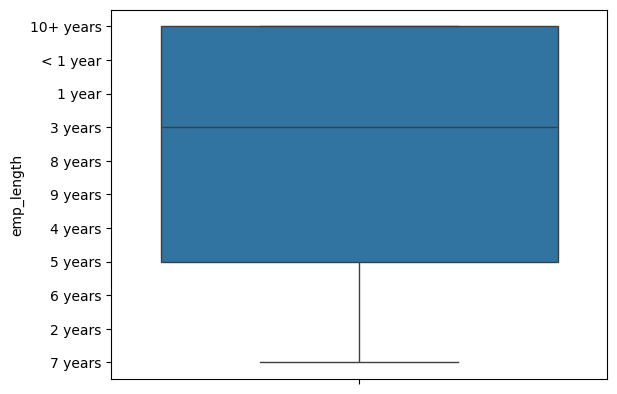

In [112]:
#@title emp_length
sns.boxplot(data["emp_length"])

In [113]:
#@title tot_coll_amt, tot_cur_bal,total_rev_hi_lim --Not a Unique Feature
print(ColDoc["tot_coll_amt"])
data["tot_coll_amt"].value_counts()/data.shape[0]

Total collection amounts ever owed


0.0       0.789906
50.0      0.001978
100.0     0.001529
75.0      0.001176
200.0     0.000805
            ...   
4891.0    0.000001
7184.0    0.000001
4242.0    0.000001
9477.0    0.000001
8567.0    0.000001
Name: tot_coll_amt, Length: 10325, dtype: float64

<Axes: ylabel='revol_util'>

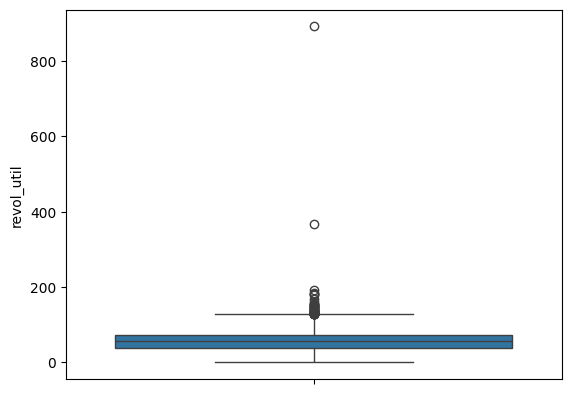

In [114]:
#@title Revol Util
sns.boxplot(data["revol_util"])

In [115]:
#@title pymnt_plan
data["pymnt_plan"].value_counts()

n    887369
y        10
Name: pymnt_plan, dtype: int64

In [116]:
#@title PreProcess -
def preprocess_dfframe(df):
  #@title Removing Id Columns
  try:
    df.set_index('id',inplace=True)
  except:
    pass
  try:
    df.drop(columns=['member_id'], inplace=True)
  except:
    pass

  #@title Removing Columns with More than 50% df missing
  columnswithincompetedf = (df.isnull().sum()/df.shape[0]).sort_values(ascending=False)[(df.isnull().sum()/df.shape[0]).sort_values(ascending=False).values>0.5].index.to_list()
  df.drop(columns=columnswithincompetedf, inplace=True)
  df.drop(columns = [ "title", "policy_code", "issue_d","pymnt_plan", 'url', "title", "zip_code", "emp_title","earliest_cr_line","last_credit_pull_d"],inplace=True)
  # Clean Employee Length
  df["emp_length"] = df["emp_length"].fillna('0').apply(lambda x:int(re.findall(r'\d+',x)[0]) if x!='0' else np.nan)

  ## Clean term
  df["term"] = df["term"].fillna('0').apply(lambda x:int(re.findall(r'\d+',x)[0]) if x!='0' else np.nan)

  ## Drop Unnecessary Columns
  for column in ['tot_coll_amt','last_pymnt_d', 'next_pymnt_d', 'tot_cur_bal', 'total_rev_hi_lim']:
    df[column].fillna(0, inplace=True)

  df["emp_title"].fillna("random", inplace=True)

  df["emp_length"] = df["emp_length"].fillna(df["emp_length"].mean())

  df["revol_util"] = df["revol_util"].fillna(df["revol_util"].median())

  df.dropna(axis=0, inplace=True)
  data.drop(columns=["last_pymnt_d"], inplace=True)

preprocess_dfframe(data)

Data Loss After Preprocessing
- 0.02 % in rows
- 40% (20) in Columns

## EDA
- We need to convert our target variable to binary
- Delete Highly Correlated Values - Numeric

- - `['funded_amnt', 'funded_amnt_inv','open_acc', 'total_rec_prncp', 'collection_recovery_fee','installment', 'out_prncp', 'out_prncp_inv', 'total_pymnt_inv','total_pymnt', 'total_rec_int', 'revol_bal','total_rev_hi_lim']`


<Axes: >

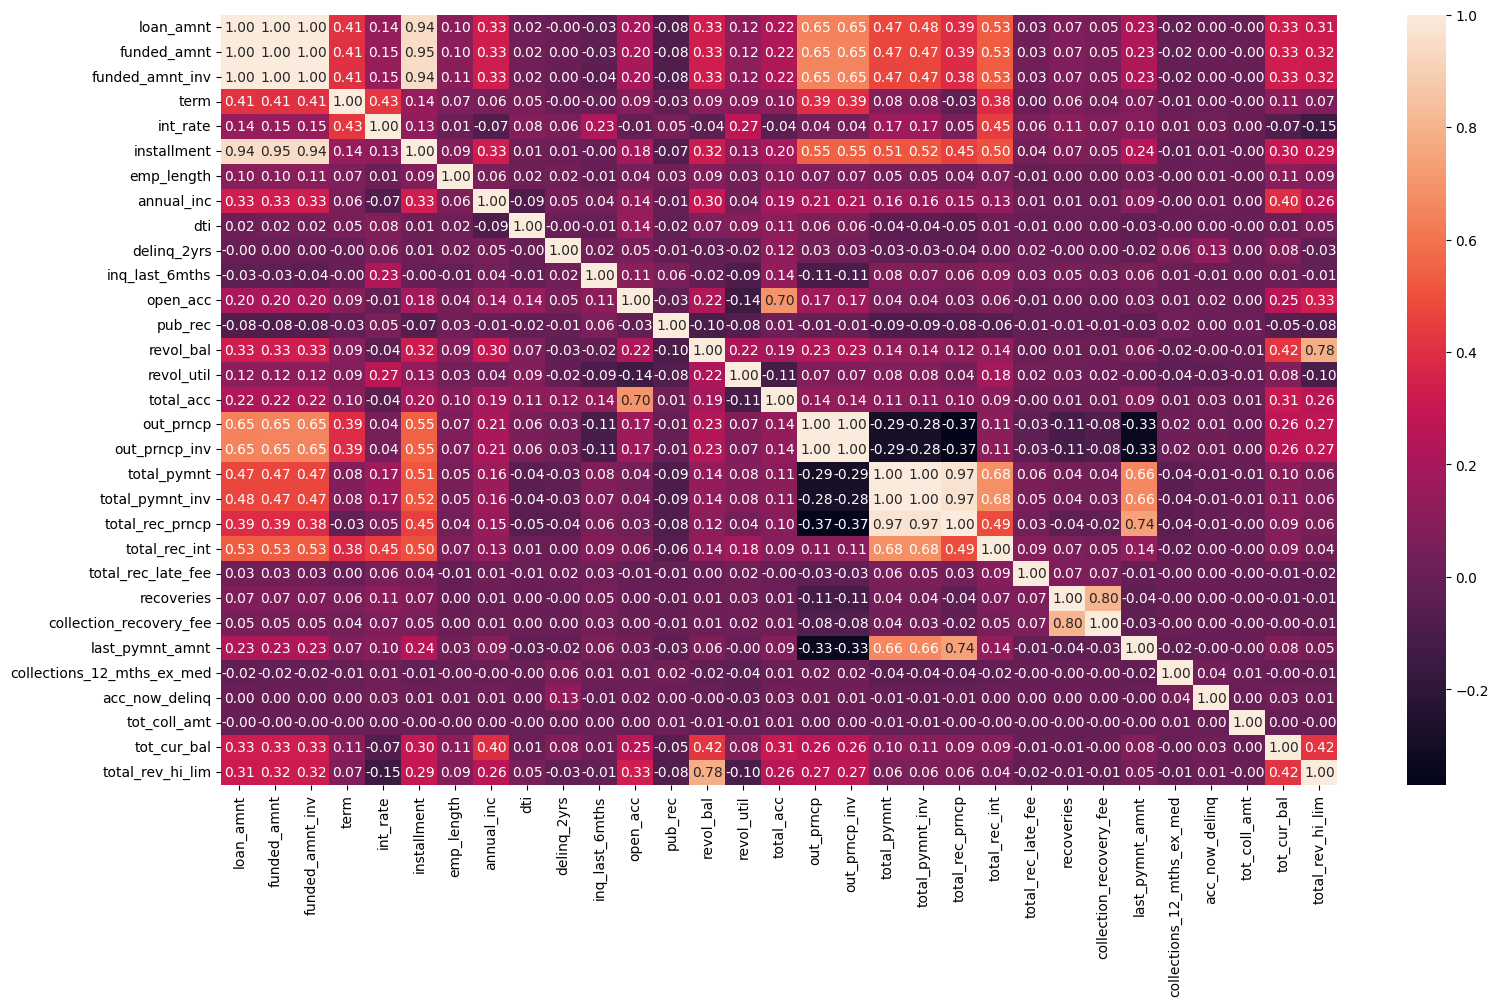

In [117]:
plt.figure(figsize=(18,10))
sns.heatmap(data.corr(), annot=True, fmt=".2f")

In [118]:
#@title Binary Target Data
data["target"] = data["loan_status"].apply(lambda x: 1 if x in ['Current', 'Fully Paid'] else 0)

In [119]:
#@title Delete Correlated Columns
correlated_column = ['funded_amnt', 'funded_amnt_inv','open_acc', 'total_rec_prncp', 'collection_recovery_fee','installment', 'out_prncp', 'out_prncp_inv', 'total_pymnt_inv','total_pymnt', 'total_rec_int', 'revol_bal','total_rev_hi_lim']
data.drop(columns=correlated_column, inplace=True)

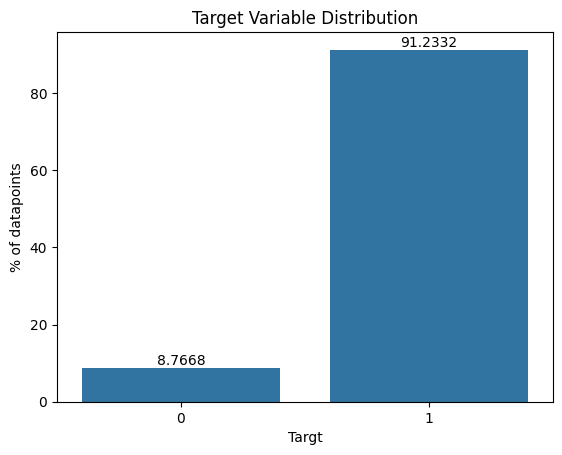

In [120]:
#@title Target Variable Distribution
ax = sns.barplot((data["target"].value_counts())*100/data.shape[0])
plt.title("Target Variable Distribution")
plt.xlabel("Targt")
plt.ylabel("% of datapoints")
for i in ax.containers:
    ax.bar_label(i,)

In [136]:
#@title Chi square test of Categorical Column
new_sample = data.copy()
#pd.concat([(data[data["target"]==0]),(data[data["target"]==1]).sample(77782)])
categorical_columns = ["grade", 'sub_grade','home_ownership', "purpose", "application_type", "verification_status"]
corrdf = pd.DataFrame()
for column in categorical_columns:
  crosstab = pd.crosstab(new_sample[column], new_sample["loan_status"])
  pvalue = round(chi2_contingency(crosstab)[1],2)
  corrdf = pd.concat([pd.DataFrame({column:[pvalue]}), corrdf],axis=1)
unimportant_columns = list(corrdf.T[corrdf.T[0]>0.05].index)
## None Columns Deteted

------------------loan_amnt---------------------------------
The listed amount of the loan applied for by the borrower. If at some point in time, the credit department reduces the loan amount, then it will be reflected in this value.
           loan_amnt             
                mean          std
target                           
0       14763.618832  8519.279613
1       14756.029511  8427.069033


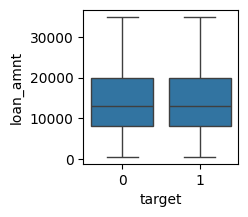

------------------term---------------------------------
The number of payments on the loan. Values are in months and can be either 36 or 60.
             term           
             mean        std
target                      
0       44.384973  11.442607
1       43.088618  10.948903


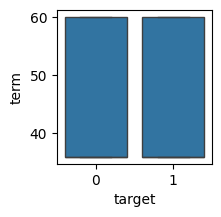

------------------int_rate---------------------------------
Interest Rate on the loan
         int_rate          
             mean       std
target                     
0       15.503359  4.422791
1       13.030281  4.316378


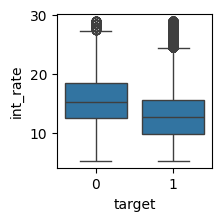

------------------emp_length---------------------------------
Employment length in years. Possible values are between 0 and 10 where 0 means less than one year and 10 means ten or more years. 
       emp_length          
             mean       std
target                     
0        5.879127  3.420429
1        6.113568  3.448134


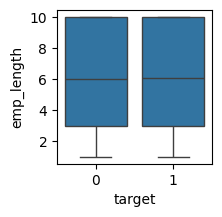

------------------annual_inc---------------------------------
The self-reported annual income provided by the borrower during registration.
          annual_inc              
                mean           std
target                            
0       68644.510342  65181.552914
1       75641.254062  64617.363613


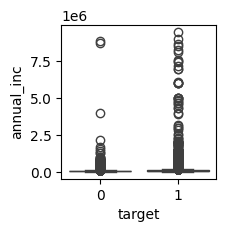

------------------dti---------------------------------
A ratio calculated using the borrower’s total monthly debt payments on the total debt obligations, excluding mortgage and the requested LC loan, divided by the borrower’s self-reported monthly income.
              dti           
             mean        std
target                      
0       18.722596   8.242172
1       18.104312  17.815315


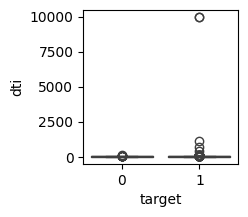

------------------delinq_2yrs---------------------------------
The number of 30+ days past-due incidences of delinquency in the borrower's credit file for the past 2 years
       delinq_2yrs          
              mean       std
target                      
0         0.324008  0.880531
1         0.313515  0.860368


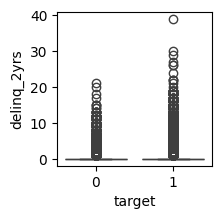

------------------inq_last_6mths---------------------------------
The number of inquiries in past 6 months (excluding auto and mortgage inquiries)
       inq_last_6mths          
                 mean       std
target                         
0            1.013859  1.352204
1            0.663731  0.950919


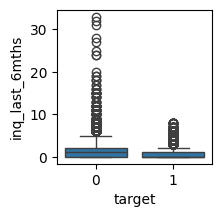

------------------pub_rec---------------------------------
Number of derogatory public records
         pub_rec          
            mean       std
target                    
0       0.174938  0.514565
1       0.197279  0.588164


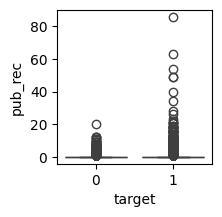

------------------revol_util---------------------------------
Revolving line utilization rate, or the amount of credit the borrower is using relative to all available revolving credit.
       revol_util           
             mean        std
target                      
0       58.211571  23.892036
1       54.767741  23.798883


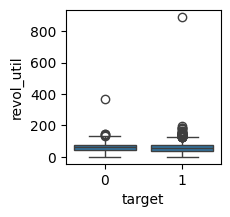

------------------total_acc---------------------------------
The total number of credit lines currently in the borrower's credit file
        total_acc           
             mean        std
target                      
0       24.640868  11.903674
1       25.329399  11.832175


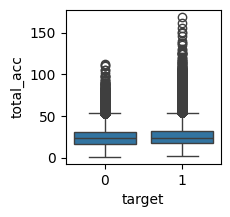

------------------total_rec_late_fee---------------------------------
Late fees received to date
       total_rec_late_fee           
                     mean        std
target                              
0                2.458626  10.272498
1                0.197774   2.772177


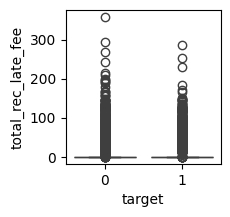

------------------recoveries---------------------------------
post charge off gross recovery
        recoveries             
              mean          std
target                         
0       523.752775  1290.091733
1         0.000000     0.000000


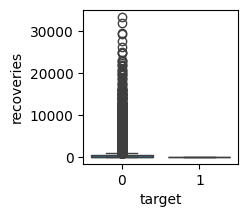

------------------last_pymnt_amnt---------------------------------
Last total payment amount received
       last_pymnt_amnt             
                  mean          std
target                             
0           464.555861   940.217890
1          2327.741630  4981.268805


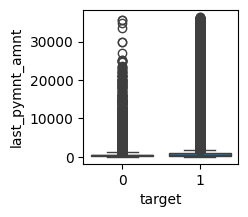

------------------collections_12_mths_ex_med---------------------------------
Number of collections in 12 months excluding medical collections
       collections_12_mths_ex_med          
                             mean       std
target                                     
0                        0.012381  0.119195
1                        0.014572  0.135543


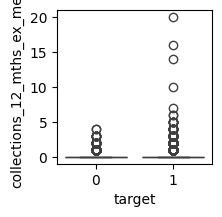

------------------acc_now_delinq---------------------------------
The number of accounts on which the borrower is now delinquent.
       acc_now_delinq          
                 mean       std
target                         
0            0.004860  0.076749
1            0.005002  0.077699


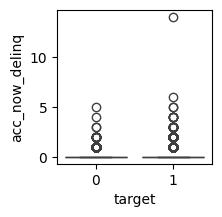

------------------tot_coll_amt---------------------------------
Total collection amounts ever owed
       tot_coll_amt              
               mean           std
target                           
0        148.182240   1458.271023
1        213.596815  10350.295961


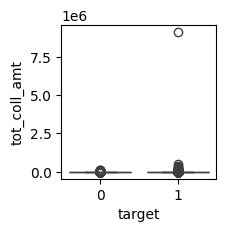

------------------tot_cur_bal---------------------------------
Total current balance of all accounts
          tot_cur_bal               
                 mean            std
target                              
0       101436.919699  133329.958164
1       131029.064593  153718.438628


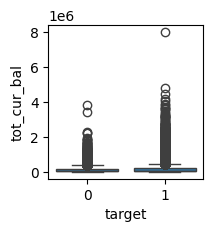

In [195]:
#@title Understanding Correlation for Numeric Columns
temp = pd.DataFrame()
for column in data.corr().columns:
  if column=='target':
    pass
  else:
    temp = data.groupby("target").agg({column:["mean", "std"]})
    print(f"------------------{column}---------------------------------")
    print(ColDoc[column])
    print(temp)
    plt.figure(figsize=(2,2))
    sns.boxplot(x=data["target"], y=data[column])
    plt.show()

In [ ]:
#@title Deleting Non Related Columns based on Analysis